<a href="https://colab.research.google.com/github/AraratRobotics/RL-Enabled-DQN-Space-Defenders/blob/main/RL_Enabled_DQN_Space_Invaders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import gym
import numpy as np
from gym import spaces
import sys
import random
import time
import pygame
import math
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
from IPython import display as ipy_display
from IPython.display import clear_output

In [ ]:
# Initialize Pygame and the font module
os.environ["SDL_VIDEODRIVER"] = "dummy"  # Use the dummy video driver
pygame.init()

class SpaceInvadersEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 30}
    def __init__(self, render_mode=None, size=1):
        super(SpaceInvadersEnv, self).__init__()
        self.size = size
        # Initialize width and height
        self.width, self.height = 100 * size, 200 * size

        # Define the observation space as a Box space (RGB images, 3 color channels)
        self.observation_space = spaces.Box(
            low=0,
            high=255,
            shape=(self.height, self.width, 3),
            dtype=np.uint8
        )

        # Define your action space
        self.action_space = spaces.Discrete(4)  # 0: left, 1: right, 2: shoot, 3: no-op

        # Initialize your game state and variables here
        self.observation_surface = pygame.Surface((self.width, self.height)) # Setup a surface for rendering the observation
        self.invader_img = pygame.image.load("/content/drive/MyDrive/Space Invaders RL/invader.png")
        self.player_img = pygame.image.load("/content/drive/MyDrive/Space Invaders RL/player.png")
        self.screen = pygame.display.set_mode((self.width, self.height))
        self.clock = pygame.time.Clock()
        self.player = pygame.Rect(self.width // 2 - 5 * size, self.height - 10 * size, 10 * size, 10 * size)
        self.current_level = 0
        self.max_levels = 5
        self.invaders_destroyed = 0
        self.moved_left_count = 0
        self.moved_right_count = 0
        self.shot_bullet_count = 0
        self.done = False
        self.collision_detected = False
        self.invaders = []
        self.bullets = []
        self.create_invaders()

    def step(self, action):
        # Check if the episode is done
        self.done = self.current_level == self.max_levels
        #if self.done:  # If the game is over, no further action should be taken.
          #  return self._get_observation(), 0, True
        #self.collision_detected = False
        # Take a step in the game based on the chosen action
        if action == 0 and self.player.x > 0:
            # Move left
            self.player.x -= 3
            self.moved_left_count += 1
        elif action == 1 and self.player.x < self.width - self.player.width:
            # Move right
            self.player.x += 3
            self.moved_right_count += 1
        elif action == 2:
            # Shoot
            self.fire_bullet()
            self.shot_bullet_count += 1

        elif action == 3:
            # No-op (no operation)
            pass

        # Move the bullets
        self.bullets = [bullet for bullet in self.bullets if bullet.y >= 0]  # Keep bullets not off-screen
        for bullet in self.bullets[:]:  # Use a slice copy to iterate over the bullets
            bullet.y -= 5  # Move the bullet up by 5 units (adjust as necessary)
            if bullet.y < 0:  # If the bullet is off the screen (y < 0)
                self.bullets.remove(bullet)  # Remove it from the bullets list

        # Move the invaders
        for invader in self.invaders:
            invader['y'] += 5
            if invader['y'] + invader['height'] >= self.height:
                self.done = True
                break

        # Check Collision
        for bullet in self.bullets[:]:  # Iterate over a copy of the bullets list
            for invader in self.invaders[:]:  # Iterate over a copy of the invaders list
                # Check if the bullet is within the horizontal bounds of the invader
                if bullet.x >= invader['x'] and bullet.x <= invader['x'] + invader['width']:
                    # Check if the bullet is within the vertical bounds of the invader
                    if bullet.y >= invader['y'] and bullet.y <= invader['y'] + invader['height']:
                        # Collision detected, remove bullet and invader, increment counter
                        self.bullets.remove(bullet)
                        self.invaders.remove(invader)
                        self.collision_detected = True
                        self.invaders_destroyed += 1
                        break  # Exit the inner loop to avoid modifying the list during iteration

        # Respawn invaders if all are dead
        if not self.invaders and not self.done:
            self.current_level += 1
            self.create_invaders()

        reward = self._compute_reward()

        return self._get_observation(), reward, self.done

    def _get_observation(self):
        self.observation_surface.fill((0, 0, 0))  # Clear the surface
        self.draw_player(self.observation_surface)
        self.draw_invaders(self.observation_surface)
        self.draw_bullets(self.observation_surface)
        observation = pygame.surfarray.array3d(self.observation_surface)
        observation = np.transpose(observation, (1, 0, 2))  # Transpose to get the correct orientation
        return observation

    def reset(self):
        # Reset episode-specific variables
        self.player = pygame.Rect(self.width // 2 - 5 * self.size, self.height - 10 * self.size, 10 * self.size, 10 * self.size)
        self.current_level = 0
        self.invaders_destroyed = 0
        self.moved_left_count = 0
        self.moved_right_count = 0
        self.shot_bullet_count = 0
        self.done = False
        self.collision_detected = False
        self.invaders = []
        self.bullets = []
        # Create a new set of invaders
        self.create_invaders()

        # Return the initial observation
        return self._get_observation()

    def draw_player(self, surface):
        player_img = pygame.transform.scale(self.player_img, (10 * self.size, 10 * self.size))
        surface.blit(player_img, (self.player.x, self.player.y))

    def draw_invaders(self, surface):
        for invader in self.invaders:
            invader_img = pygame.transform.scale(self.invader_img, (invader['width'], invader['height']))
            surface.blit(invader_img, (invader['x'], invader['y']))

    def draw_bullets(self, surface):
        for bullet in self.bullets:
            pygame.draw.rect(surface, (255, 255, 255), bullet)

    def create_invaders(self):
        self.invaders.clear()
        max_invaders = 10
        for _ in range(max_invaders):
            invader = {
                'x': random.uniform(10, self.width - 10),
                'y': random.uniform(-200, 0),
                'width': 10 * self.size,
                'height': 10 * self.size,
            }
            self.invaders.append(invader)

    def fire_bullet(self):
        bullet = pygame.Rect(self.player.x + self.player.width // 2, self.player.y, 2 * self.size, 3 * self.size)
        self.bullets.append(bullet)

    def _compute_reward(self):
        # Initialize the reward for this step
        step_reward = 0

        # Add reward for destroyed invaders
        step_reward += self.invaders_destroyed * 1
        step_reward += self.moved_left_count * 0.01
        step_reward += self.moved_right_count * 0.01
        step_reward += self.shot_bullet_count * 0.0001
        step_reward += self.current_level * 15000
        step_reward += (self.shot_bullet_count - self.invaders_destroyed) * -0.0004
        # Subtract penalty for bullets that didn't hit anything
        # Assuming you keep track of bullets fired and invaders destroyed
        #missed_shots = max(0, len(self.bullets) - self.invaders_destroyed)
        #step_reward -= missed_shots * 0.05  # Assuming a penalty of 0.05 for each missed shot

        # Reset the number of destroyed invaders after the reward is calculated
        self.invaders_destroyed = 0
        self.moved_left_count = 0
        self.moved_right_count = 0
        self.shot_bullet_count = 0

        return step_reward

    def control_frame_rate(self, fps=120):
        self.clock.tick(fps)

    def render(self, mode='human'):
        if mode == 'human':
            # Handle the events (if any) - This might be optional in Colab
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.close()

            # Clear the screen and draw the game state
            self.screen.fill((0, 0, 0))  # Replace with the desired background color
            self.draw_player(self.screen)
            self.draw_invaders(self.screen)
            self.draw_bullets(self.screen)
            pygame.display.flip()

            # Capture the screen and display it using Matplotlib
            screenshot = pygame.surfarray.array3d(self.screen)
            screenshot = screenshot.transpose([1, 0, 2])  # Transpose to a format compatible with Matplotlib
            plt.imshow(screenshot)
            plt.axis('off')
            ipy_display.display(plt.gcf())
            clear_output(wait=True)  # Clear the output to update the figure
    """def render(self, mode='human'):
        if mode == 'human':
            # Clear the screen and draw the game state for human viewing
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    self.close()
            self.screen.fill((0, 0, 0))  # Replace with the desired background color
            self.draw_player(self.screen)
            self.draw_invaders(self.screen)
            self.draw_bullets(self.screen)
            pygame.display.flip()
        # Additional rendering modes can be handled here if needed"""

    def close(self):
        # Close the Pygame window
        pygame.quit()

KeyboardInterrupt: ignored

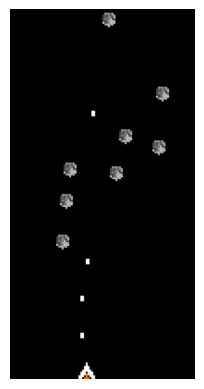

In [ ]:
def test_environment(env, num_episodes=5):
    for episode in range(num_episodes):
        done = False
        state = env.reset()
        total_reward = 0

        while not done:
            env.render()
            env.control_frame_rate(1200)  # Control FPS

            action = env.action_space.sample()
            state, reward, done = env.step(action)
            total_reward += reward

        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

    env.close()

# Initialize your environment
env = SpaceInvadersEnv()

# Test the environment
test_environment(env)

In [ ]:
# Initialize environment
env = SpaceInvadersEnv()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Named tuple for storing experiences
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [ ]:
# DQN architecture
class DQN(nn.Module):
    def __init__(self, observation, outputs):
        height, width, _ = observation
        #print('Width initial', width)
        #print('Height initial', height)
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2)
        #print('Width after conv1', width)
        #print('Height after conv1', height)
        self.bn1 = nn.BatchNorm2d(8)
        #print('Width after bn1', width)
        #print('Height after bn1', height)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2)
        #print('Width after conv2', width)
        #print('Height after conv2', height)
        self.bn2 = nn.BatchNorm2d(16)
        #print('Width after bn2', width)
        #print('Height after bn2', height)

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1

        convw = conv2d_size_out(conv2d_size_out(width))
        #print('convw', convw)
        convh = conv2d_size_out(conv2d_size_out(height))
        #print('convw', convw)
        linear_input_size = convw * convh * 16
        #print('Linear Input Size', linear_input_size)
        #print('Outputs', outputs)
        self.head = nn.Linear(linear_input_size, outputs)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        #x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))
"""class DQN(nn.Module):
  def __init__(self, observation, outputs):
      super(DQN, self).__init__()
      self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
      self.bn1 = nn.BatchNorm2d(16)
      self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
      self.bn2 = nn.BatchNorm2d(32)
      self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)
      self.bn3 = nn.BatchNorm2d(64)

      def conv2d_size_out(size, kernel_size=5, stride=2):
          return (size - (kernel_size - 1) - 1) // stride + 1

      height, width, _ = observation
      convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(width)))
      convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(height)))
      linear_input_size = convw * convh * 64

      self.fc1 = nn.Linear(linear_input_size, 512)
      self.fc2 = nn.Linear(512, 128)
      self.head = nn.Linear(128, outputs)

  def forward(self, x):
      x = F.relu(self.bn1(self.conv1(x)))
      x = F.relu(self.bn2(self.conv2(x)))
      x = F.relu(self.bn3(self.conv3(x)))
      x = x.view(x.size(0), -1)  # Flatten the tensor
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      return self.head(x)"""

'class DQN(nn.Module):\n  def __init__(self, observation, outputs):\n      super(DQN, self).__init__()\n      self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)\n      self.bn1 = nn.BatchNorm2d(16)\n      self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)\n      self.bn2 = nn.BatchNorm2d(32)\n      self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2)\n      self.bn3 = nn.BatchNorm2d(64)\n\n      def conv2d_size_out(size, kernel_size=5, stride=2):\n          return (size - (kernel_size - 1) - 1) // stride + 1\n\n      height, width, _ = observation\n      convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(width)))\n      convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(height)))\n      linear_input_size = convw * convh * 64\n\n      self.fc1 = nn.Linear(linear_input_size, 512)\n      self.fc2 = nn.Linear(512, 128)\n      self.head = nn.Linear(128, outputs)\n\n  def forward(self, x):\n      x = F.relu(self.bn1(self.conv1(x)))\n      x = F.relu(self.bn2(self.conv2(

In [ ]:
# Hyperparameters
BATCH_SIZE = 128
GAMMA = 0.998
EPS_START = 0.998
EPS_END = 0.005
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

n_actions = env.action_space.n
observation = env.reset().shape

policy_net = DQN(observation, n_actions).to(device)
target_net = DQN(observation, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(11000)

steps_done = 0

def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations(show_result=False):
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [ ]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


<Figure size 640x480 with 0 Axes>

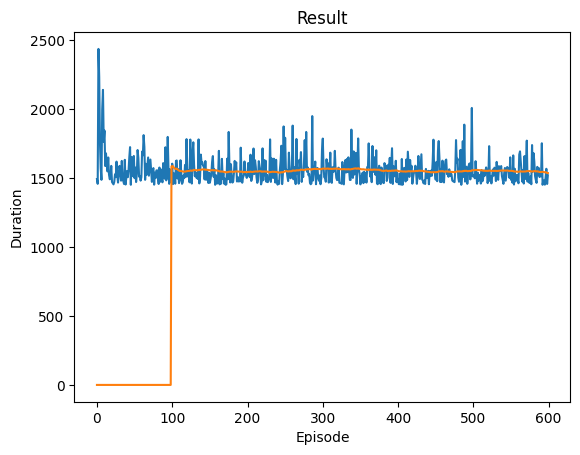

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
"""model_save_dir = '/content/drive/MyDrive/Space Invaders RL/Policy'
os.makedirs(model_save_dir, exist_ok=True)  # Create the directory if it doesn't exist"""
# Main training loop
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50
for i_episode in range(num_episodes):
    state = env.reset()
    state = env._get_observation()
    state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).to(device).float()
    for t in count():
        action = select_action(state)
        observation, reward, done = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = observation
            next_state = torch.from_numpy(next_state).permute(2, 0, 1).unsqueeze(0).to(device).float()
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()

        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break
    # Save the model weights at the end of each episode
    """if i_episode % 10 == 0 or i_episode == num_episodes - 1:
        save_path_policy = os.path.join(model_save_dir, f'policy_net_episode_{i_episode}.pth')
        save_path_target = os.path.join(model_save_dir, f'target_net_episode_{i_episode}.pth')
        torch.save(policy_net.state_dict(), save_path_policy)
        torch.save(target_net.state_dict(), save_path_target)"""

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

Episode: 1, Agent: trained, Total Reward: -0.4560000000000124, Duration: 1520
Episode: 2, Agent: trained, Total Reward: -0.4479000000000118, Duration: 1493
Episode: 3, Agent: trained, Total Reward: 0.5348000000000251, Duration: 1552
Episode: 4, Agent: trained, Total Reward: -0.4398000000000112, Duration: 1466
Episode: 5, Agent: trained, Total Reward: -0.43830000000001107, Duration: 1461
Episode: 6, Agent: trained, Total Reward: 0.5372000000000353, Duration: 1544
Episode: 7, Agent: trained, Total Reward: 1.5646000000000442, Duration: 1454
Episode: 8, Agent: trained, Total Reward: 1.4179000000000588, Duration: 1943
Episode: 9, Agent: trained, Total Reward: -0.450600000000012, Duration: 1502
Episode: 10, Agent: trained, Total Reward: 0.5420000000000271, Duration: 1528
Episode: 11, Agent: trained, Total Reward: -0.43530000000001084, Duration: 1451
Episode: 12, Agent: trained, Total Reward: 1.5619000000000463, Duration: 1463
Episode: 13, Agent: trained, Total Reward: 1.553200000000035, Dura

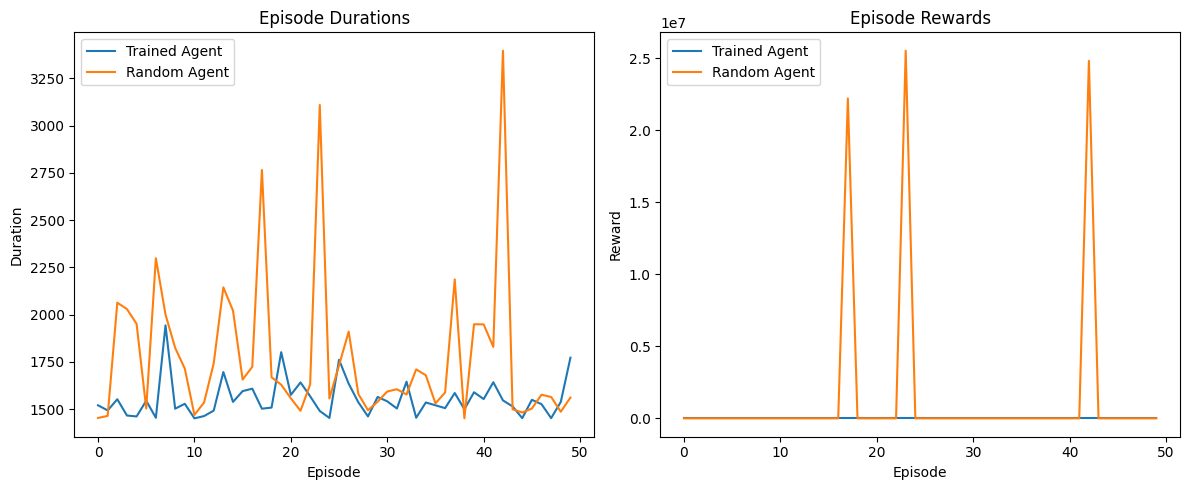

In [ ]:
def test_environment(env, policy_net, agent_type='trained', num_episodes=5):
    rewards_per_episode = []
    durations_per_episode = []

    for episode in range(num_episodes):
        done = False
        state = env.reset()
        state = torch.from_numpy(state).permute(2, 0, 1).unsqueeze(0).to(device).float()
        total_reward = 0
        steps = 0

        while not done:
            #env.render()
            env.control_frame_rate(120)  # Control FPS to a reasonable rate

            if agent_type == 'trained':
                # Use the trained policy network to select an action
                action = policy_net(state).max(1)[1].view(1, 1)
            elif agent_type == 'random':
                # Sample a random action from the action space
                action = torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

            next_state, reward, done = env.step(action.item())
            next_state = torch.from_numpy(next_state).permute(2, 0, 1).unsqueeze(0).to(device).float()
            state = next_state
            total_reward += reward
            steps += 1

        rewards_per_episode.append(total_reward)
        durations_per_episode.append(steps)
        print(f"Episode: {episode + 1}, Agent: {agent_type}, Total Reward: {total_reward}, Duration: {steps}")

    env.close()
    return rewards_per_episode, durations_per_episode

# Initialize your environment
env = SpaceInvadersEnv()

# Use the trained policy network for testing
trained_rewards, trained_durations = test_environment(env, policy_net, agent_type='trained', num_episodes=50)

# Close and re-initialize Pygame and environment for the next test
env.close()
pygame.quit()
pygame.init()
env = SpaceInvadersEnv()  # Recreate the environment

# Test with a random policy
random_rewards, random_durations = test_environment(env, policy_net, agent_type='random', num_episodes=50)

# Now you can compare the rewards and durations between the trained agent and random agent
# You could use plotting functions here to visualize the comparison

# Plot the results
plt.figure(figsize=(12, 5))

# Plot durations
plt.subplot(1, 2, 1)
plt.plot(trained_durations, label='Trained Agent')
plt.plot(random_durations, label='Random Agent')
plt.title('Episode Durations')
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.legend()

# Plot rewards
plt.subplot(1, 2, 2)
plt.plot(trained_rewards, label='Trained Agent')
plt.plot(random_rewards, label='Random Agent')
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model weights

torch.save(policy_net.state_dict(), 'policy_net_weights.pth')

NameError: ignored